# **Introduction to Langgraph** 


## 📚  **Cognitive Architecture:**  
  - A term used in AI to describe models of **human reasoning** and their **computer implementations**.

- **LLM Cognitive Architecture:**  
  - Refers to the **sequence of steps** in an LLM application.

- **Steps in LLM Applications:**  
  - Examples of steps include:
    - **Retrieval of relevant documents** (e.g., using RAG — Retrieval-Augmented Generation).
    - **Calling an LLM with a chain-of-thought prompt** to guide multi-step reasoning. -->


![Screenshot 2024-08-20 at 3.11.22 PM.png](https://cdn.prod.website-files.com/6720fd49425e367c9ec40a97/67763d0c2c765ddc16efcfd0_67763cbb89e7793bdd588306_key%2520conceps.jpeg) 

# **🧠 What Is `StateGraph`?**
`StateGraph` is the core class in LangGraph used to **define a directed graph of nodes that share and modify a central state dictionary.**

### **🔧 What Goes Inside a `StateGraph`?**
1. **State:** (a `TypedDict`) defines the structure of data passed between nodes

2. **Nodes:** Named `functions` that operate on that state

3. **Edges:** `Connections` between nodes (and optional conditional logic)

4. **Reducers:** Define `how to combine state updates` from different nodes

# **🧩State**

When we define a LangGraph `StateGraph`, we use a [state schema](https://langchain-ai.github.io/langgraph/concepts/low_level/#state).

The state schema serves as the **input schema for all Nodes and Edges in the graph and represents the structure and types of data that our graph will use.**

All nodes are expected to communicate with that schema.

LangGraph offers flexibility in how you define your state schema, accommodating various Python [types](https://docs.python.org/3/library/stdtypes.html#type-objects) and validation approaches!

> Let's use the `TypedDict` class from python's `typing` module as our schema, which **provides type hints for the keys.**

In [1]:
from typing_extensions import TypedDict

class State(TypedDict): # state = {"graph_state": "empty graph"}
    graph_state: str

## **🧿Nodes**

[Nodes](https://langchain-ai.github.io/langgraph/concepts/low_level/#nodes) are just **python functions.**

The first positional argument is the state, as defined above.

Because the state is a `TypedDict` with schema as defined above, each node can access the key, `graph_state`, with `state['graph_state']`.

Each node returns a new value of the state key `graph_state`.
  
By default, the new value returned by each node **[will override](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers)** the prior state value. 

In [2]:
def node_1(state: State): # output is an updated State object
    print("---Node 1--- state:", state)
    return {"graph_state": state['graph_state'] +" I am happy!"}


# def node_2(state: State):
#     print("---Node 2--- state:", state)
#     return {"graph_state": state['graph_state'] +" happy!"}


## **➡️Normal Edges**

[Edges](https://langchain-ai.github.io/langgraph/concepts/low_level/#edges) connect the nodes.

1. **Normal Edges** are used if you want to *always* go from, for example, `node_1` to `node_2`.

 

## **🧱Graph Construction**

Now, we build the graph from our [components](
https://langchain-ai.github.io/langgraph/concepts/low_level/) defined above.

The [StateGraph class](https://langchain-ai.github.io/langgraph/concepts/low_level/#stategraph) is the graph class that we can use.
 
First, we initialize a `StateGraph` with the `State` class we defined above. Then, we add our nodes and edges.

We use the [`START` Node, a special node](https://langchain-ai.github.io/langgraph/concepts/low_level/#start-node) that sends user input to the graph, to indicate where to start our graph.
 
The [`END` Node](https://langchain-ai.github.io/langgraph/concepts/low_level/#end-node) is a special node that represents a terminal node. 

Finally, we [compile our graph](https://langchain-ai.github.io/langgraph/concepts/low_level/#compiling-your-graph) to perform a few basic checks on the graph structure. 

We can visualize the graph as a [Mermaid diagram](https://github.com/mermaid-js/mermaid).


---

# **🕸️ 1. The Simplest Graph**

Let's build a simple graph with 2 nodes, normal edges and one LLM call 



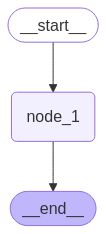

In [5]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict



#################### Define State ##########################
class State(TypedDict): # state = {"graph_state": "empty graph"}
    graph_state: str


######### Define functions to be used as Nodes ###########
def node_1(state: State): # output is an updated State object
    print("---Node 1--- state:", state)
    return {"graph_state": state['graph_state'] +" I am happy!"}




# def node_2(state: State):
#     print("---Node 2--- state:", state)
#     return {"graph_state": state['graph_state'] +" happy!"}

##################### Build graph ##########################
builder = StateGraph(State)

## Create Nodes
builder.add_node("node_1", node_1)
# builder.add_node("node_2", node_2)


# Logic (Edges)
builder.add_edge(START, "node_1")
# builder.add_edge("node_1", 'node_2')
builder.add_edge("node_1", END)


############### Compile Graph ###############################
happy_graph = builder.compile()

# View
# graph.get_graph().print_ascii()
display(Image(happy_graph.get_graph(xray=True).draw_mermaid_png()))

In [6]:
happy_graph.invoke({"graph_state" : "Hi, this is Lance."})

---Node 1--- state: {'graph_state': 'Hi, this is Lance.'}


{'graph_state': 'Hi, this is Lance. I am happy!'}

## **Example: 🤖 Chatbot**
**One LLM call only**. This is useful mostly when it’s part of a larger application that makes use of an LLM for achieving a specific task, such as translating or summarizing a piece of text.

    Ex: The chatbot will respond directly to user messages 

In [7]:
# read api_key from file
with open(r'C:\Users\Seyed Barabadi\Downloads\Gen AI\Incedo Teaching\api_keys.txt', 'r') as file:
    api_key = file.read()


# Set loaded api_key as OPENAI_API_KEY environmental variable
import os
os.environ["OPENAI_API_KEY"] = api_key

# api_key

### 💬  Using `messages` as state key

With these foundations in place, we can now use [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages) in our graph state.

Let's define our state, `State`, as a `TypedDict` with a single key: `messages`.

`messages` is simply a list of messages, as we defined above (e.g., `HumanMessage`, etc). -->

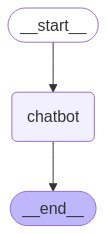

In [8]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage, AnyMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState


model = ChatOpenAI(model='gpt-3.5-turbo')


class State(TypedDict):
    # Messages have the type "list". The `add_messages` 
    # function in the annotation defines how this state should 
    # be updated (in this case, it appends new messages to the 
    # list, rather than replacing the previous messages)
    # messages: Annotated[list[AnyMessage], add_messages]
    messages: list[AnyMessage]



def chatbot(state: State):
    answer = model.invoke(state["messages"])
    return {"messages": [answer]}



builder = StateGraph(State)


builder.add_node("chatbot", chatbot)

builder.add_edge(START, 'chatbot')
builder.add_edge('chatbot', END)


chatbot_graph = builder.compile()
display(Image(chatbot_graph.get_graph(xray=True).draw_mermaid_png()))

## **🔮 Graph Invocation**

The compiled graph implements the [runnable](https://python.langchain.com/docs/concepts/runnables/) protocol which means it can be `invoke`d.

The input is a dictionary `{"graph_state": "Hey, this is customer number 39. My router is not working!"}`, which sets the initial value for our graph state dict.

When `invoke` is called, the graph starts execution from the `START` node.

It progresses through the defined nodes (`node_1` and `node_2`) in order.

Each node function receives the current state and returns a new value, which overrides the graph state.

The execution continues until it reaches the `END` node.




---



In [9]:
input = {"messages": [HumanMessage('Hey, this is customer number 39. My router is not working!')]}

answer = chatbot_graph.invoke(input)

for m in answer['messages']:
    m.pretty_print()

================================== Ai Message ==================================

Hi customer number 39, I'm sorry to hear that your router is not working. Can you please provide me with some more details about the issue you are experiencing? Have you tried troubleshooting it or resetting it? Let me know so I can assist you further.


The input to the graph was in the same shape as the State object we defined earlier; that is, we sent in a list of messages in the messages key of a dictionary.

## ❌**We have a problem!**

As we discussed, each node will return a new value for our state key `messages`.

But, this new value [will override](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) the prior `messages` value.
 
As our graph runs, we want to **append** messages to our `messages` state key.
 
We can use [reducer functions](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) to address this.

--- 

## 🧮 **Reducers**

Reducers allow us to specify **how state updates are performed.**

If no reducer function is specified, then it is assumed that updates to the key should *override it* as we saw before.
 
But, to append messages, we can use the pre-built `add_messages` reducer.

This ensures that any messages are appended to the existing list of messages.



### **1. `add_messages`**
To append messages, we can use the pre-built `add_messages` reducer.

This ensures that any messages are appended to the existing list of messages. We simply need to use `Annotated` on our `messages` key with the `add_messages` reducer function as metadata.

In [10]:
from typing import Annotated
from langgraph.graph.message import add_messages


# Override
class State(TypedDict):
    messages: list[AnyMessage]


# Append
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

To go a bit deeper, we can see how the `add_messages` reducer works in isolation. -->

In [11]:
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, ToolMessage

# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='0c0cbc91-d235-4643-a04a-2a68a668ec74'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='99d47089-aedb-465f-821f-b4eb648ab24e'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='20c728ba-61d1-4e0e-9c92-e4d6fdcd7b44')]

🎯 Since having a list of messages in graph state is so common, LangGraph has a pre-built [`MessagesState`](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate)! 

`MessagesState` is defined: 

* With a pre-build single `messages` key
* This is a list of `AnyMessage` objects 
* It uses the `add_messages` reducer

We'll usually use `MessagesState` because it is less verbose than defining a custom `TypedDict`, as shown above

In [12]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # this is by defenition here: 
    # messages: Annotated[list[AnyMessage], add_messages]
    # Add any keys needed beyond messages, which is pre-built 
    pass

In [13]:
class ExtendedMessagesState(MessagesState):
    extra_key_1: str
    extra_key_2: int

### **2. `operator.add`**

For example, in this case let's append the `int` values returned from each node rather than overwriting them.

We just need a reducer that can perform this: `operator.add` is a function from Python's built-in `operator` module.

When `operator.add` is applied to lists, it performs list concatenation.

In [14]:
import operator

# Initial state
initial_messages = [2, 4, 6]

# New message to add
new_message = [10]

# Test
operator.add(initial_messages , new_message)

[2, 4, 6, 10]

---

# **2. ⛓️ Chain**

**Multiple LLM calls**, in a predefined sequence (that is, different invocations of the application do the same sequence of LLM calls, albeit with different inputs and results).


## **Multiple Schema States**

Schema States are type hints and not restrictions! 

They can be used by static type checkers (like [mypy](https://github.com/python/mypy)) or IDEs to catch potential type-related errors before the code is run. 

> But they are not enforced at runtime!

## **1.Private State**

First, let's cover the case of passing [private state](https://langchain-ai.github.io/langgraph/how-tos/pass_private_state/) between nodes.

This is useful for anything needed as part of the **intermediate working logic of the graph, but not relevant for the overall graph input or output.**

We'll define an `OverallState` and a `PrivateState`.

`node_2` uses `PrivateState` as input, but writes out to `OverallState`.

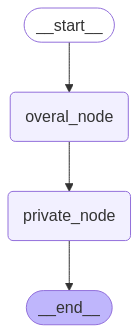

In [18]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END


class OverallState(TypedDict):
    overal_variable: int


class PrivateState(TypedDict):
    private_variable: int



def overal_node(state: OverallState) -> PrivateState:
    print("---overal_node--- state:", state)
    return {"private_variable": state['overal_variable'] + 10}


def private_node(state: PrivateState) -> OverallState:
    print("---private_node--- state:", state)
    return {"overal_variable": state['private_variable'] + 1}



# Build graph
builder = StateGraph(OverallState)
builder.add_node("overal_node", overal_node)
builder.add_node("private_node", private_node)

# Logic
builder.add_edge(START, "overal_node")
builder.add_edge("overal_node", "private_node")
builder.add_edge("private_node", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
graph.invoke({"overal_variable" : 1})

---overal_node--- state: {'overal_variable': 1}
---private_node--- state: {'private_variable': 11}


{'overal_variable': 12}

`private_variable` is only included in `PrivateState`.

`private_node` uses `PrivateState` as input, but writes out to `OverallState`.

So, we can see that `private_variable` is excluded from the graph output because it is not in `OverallState`.

## **2. Input / Output Schema**

By default, `StateGraph` takes in a single schema and all nodes are expected to communicate with that schema. 

However, it is also possible to [define explicit input and output schemas for a graph](https://langchain-ai.github.io/langgraph/how-tos/input_output_schema/?h=input+outp).

Often, in these cases, we define an "internal" schema that contains *all* keys relevant to graph operations.

But, we use specific `input` and `output` schemas to constrain the input and output.

First, let's just run the graph with a single schema.

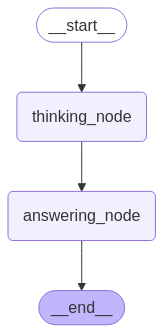

In [20]:
class OverallState(TypedDict):
    question: str
    answer: str
    notes: str



def thinking_node(state: OverallState):
    return {"answer": "bye", "notes": "... his name is Lance"}



def answering_node(state: OverallState):
    return {"answer": "bye Lance"}



graph = StateGraph(OverallState)
graph.add_node("answering_node", answering_node)
graph.add_node("thinking_node", thinking_node)


graph.add_edge(START, "thinking_node")
graph.add_edge("thinking_node", "answering_node")
graph.add_edge("answering_node", END)

graph = graph.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

### **Notice that the output of `invoke` contains all keys in `OverallState`.**

In [21]:
graph.invoke({"question":"hi"})

{'question': 'hi', 'answer': 'bye Lance', 'notes': '... his name is Lance'}

Now, let's use a specific `input` and `output` schema with our graph.

Here, `input` / `output` schemas perform *filtering* on what keys are permitted on the input and output of the graph. 

In addition, we can use a type hint `state: InputState` to specify the input schema of each of our nodes.

This is important when the graph is using multiple schemas.

We use type hints below to, for example, show that the output of `answer_node` will be filtered to `OutputState`. 

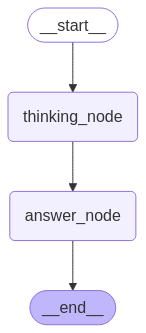

{'answer': 'bye Lance'}

In [22]:
class InputState(TypedDict):
    question: str


class OutputState(TypedDict):
    answer: str


class OverallState(TypedDict):
    question: str
    answer: str
    notes: str



def thinking_node(state: InputState):
    return {"answer": "bye", 
            "notes": "... his is name is Lance"}


def answer_node(state: OverallState) -> OutputState:
    return {"answer": "bye Lance"}



graph = StateGraph(OverallState,
                   input=InputState, 
                   output=OutputState)

graph.add_node("answer_node", answer_node)
graph.add_node("thinking_node", thinking_node)


graph.add_edge(START, "thinking_node")
graph.add_edge("thinking_node", "answer_node")
graph.add_edge("answer_node", END)

graph = graph.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

graph.invoke({"question":"hi"})

We can see the `output` schema constrains the output to only the `answer` key.

## **Attention!**
If the return of a node
```python
def answer_node(state: OverallState):
    return {"answer": "bye Lance",
            "notes": state['notes']}
```
contradcits the declared `output`,

```python

Class OutputState(TypedDict):
    answer: str
    

graph = StateGraph(OverallState, 
                   input=InputState, 
                   output=OutputState)
```
`OutputState` dictates the final return.
In this case return is:
```pyhton
{'answer': 'bye Lance'}

```

## OR


```python
def answer_node(state: OverallState):
    return {"answer": "bye Lance"}
```


```python

Class OutputState(TypedDict):
    answer: str
    note: str
    
```

```pyhton
{'answer': 'bye Lance', 'notes': '... his is name is Lance'}

```


---

## **Example: 🗣️ text-to-SQL Bot**
text-to-SQL application, which receives as input from the user a natural language description of some calculation to make over a database. 
    


1. One LLM call to generate a SQL query from the natural language query, provided by the user, and a description of the database contents, provided by the developer.

2. Another LLM call to write an explanation of the query appropriate for a nontechnical user, given the query generated in the previous call. This one could then be used to enable the user to check if the generated query matches his request.

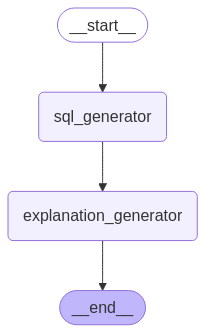

In [23]:
from typing import Annotated, TypedDict

from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages


################### ALL STATES #####################################################

class OveralState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages] # to track conversation history
    user_query: str # user input
    generated_sql_query: str # output of sql_generator Node
    generated_sql_explanation: str # output of explain_generator Node



class InputState(TypedDict):
    user_query: str
    


class OutputState(TypedDict):
    messages: list 
    generated_sql_query: str
    generated_sql_explanation: str


################# ALL NODES ###################################
# useful to generate SQL queries
model_sql_generator = ChatOpenAI(model='gpt-3.5-turbo', temperature=0.1)

# useful to generate natural language outputs
model_explanation_generator = ChatOpenAI(model='gpt-4', temperature=0.7)



def sql_generator(state): # the OveralState is passed here unless (state: InputState) is explicitly mentioned
    # state {'messages': [], 'user_query': 'What is the total sales for each product?'}
    generator_system_message = SystemMessage( # constant for all calls to this function
            "You are a helpful data analyst, who generates SQL queries for users based on their questions. Return just the SQL query without any further info.")

    user_message = HumanMessage(state["user_query"]) # changes at each call
   
    all_input_messages = [  # includes all the inputs for LLM call
                          generator_system_message,
                          *state["messages"], # *state["messages"] is empty at this stage, unless we have memory to store messages from previous calls
                          user_message
                          ] 
            

    generated_sql = model_sql_generator.invoke(all_input_messages)

    return {
        "generated_sql_query": generated_sql.content,
        # update conversation history
        # "messages": [user_message, generated_sql], # only user's query and generated_sql are appended to messages
        "messages": [generator_system_message, user_message, generated_sql], # all system messages are also appended
    }




                                       
def explanation_generator(state):
    explainer_system_message = SystemMessage(
            "You are a helpful data analyst, who explains SQL queries to users in plain English. Returrn No sql query just explanation.")

    # print('*state[messages] in generator:', *state["messages"])
    all_input_messages = [ 
        explainer_system_message,
        *state["messages"], # includes [user_message, generated_sql_query] from generator
    ]

    generated_explanation = model_explanation_generator.invoke(all_input_messages)
    print(generated_explanation)
    # print("generated_sql_query", state["messages"]['generated_sql_query'])
    return {
    
        "generated_sql_explanation": generated_explanation.content,
        "messages": [generated_explanation] # update conversation history
    }


################# BUILD THE GRAPH ##################################

builder = StateGraph(OveralState, 
                     input=InputState, 
                     output=OutputState)


builder.add_node("sql_generator", sql_generator)
builder.add_node("explanation_generator", explanation_generator)


builder.add_edge(START, "sql_generator")
builder.add_edge("sql_generator", "explanation_generator")
builder.add_edge("explanation_generator", END)


graph = builder.compile()
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

## 🔮 `invoke()` Behavior in LangGraph

| Feature                     | Description                                                                 |
|-----------------------------|-----------------------------------------------------------------------------|
| 🚀 `invoke()`               | Runs the **entire graph synchronously**                                     |
| ⏱️ Execution Order         | **Waits** for each step to finish before moving to the next                  |
| 🎯 Output                  | Returns the **final state** after all nodes have completed                   |


---



In [24]:
# Example usage
result = graph.invoke({"user_query": "What is the total sales for each product?"})
print(result)

content='This SQL query will give you a list of all products in your "sales" table, along with the total sales amount for each product. The "SUM(sales_amount)" function adds up all the sales for each product, and "GROUP BY product_name" groups the results by the name of the product. So, for each unique product name in the sales table, you\'ll get the total sales amount.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 83, 'prompt_tokens': 103, 'total_tokens': 186, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4-0613', 'system_fingerprint': None, 'id': 'chatcmpl-BMmTWcIIQS8aCHofHZa404NqgeHg3', 'finish_reason': 'stop', 'logprobs': None} id='run-49dc1855-82a8-42fe-ab00-2f97d78ad463-0' usage_metadata={'input_tokens': 103, 'output_tokens': 83, 'total_tokens': 186, 'input_

In [25]:
result.keys()

dict_keys(['messages', 'generated_sql_query', 'generated_sql_explanation'])

In [26]:
for m in result['messages']:
    m.pretty_print()

================================ System Message ================================

You are a helpful data analyst, who generates SQL queries for users based on their questions. Return just the SQL query without any further info.
================================ Human Message =================================

What is the total sales for each product?
================================== Ai Message ==================================

SELECT product_name, SUM(sales_amount) AS total_sales
FROM sales
GROUP BY product_name;
================================== Ai Message ==================================

This SQL query will give you a list of all products in your "sales" table, along with the total sales amount for each product. The "SUM(sales_amount)" function adds up all the sales for each product, and "GROUP BY product_name" groups the results by the name of the product. So, for each unique product name in the sales table, you'll get the total sales amount.


## 📌 Key Notes

| Element              | Affected Node(s)                   | Purpose                                                |
|----------------------|------------------------------------|--------------------------------------------------------|
| `input=InputState`   | First node after `START` (→ `"sql_generator"`) | Validates the structure of the initial input to the graph but passes the full state to it |
| `output=OutputState` | Final return value of `graph.invoke(...)` | Filters the final state to return only specific keys   |

---

## 🧠 What Happens Internally


1️⃣	`graph.invoke(input_dict)` validates input against `InputState`

2️⃣	LangGraph merges the input into a full `OverallState`

3️⃣	First node after `START` (`sql_generator`) **receives the complete `OverallState`**

4️⃣	Nodes update parts of `OverallState` as they execute

5️⃣	Final node before `END` (`explanation_generator`) also **receives and returns the full OverallState**

6️⃣	LangGraph **extracts only the keys defined in `OutputState` from the final state and return them**


---

`%pip install langchain`

## **🏋️ Exercise!**
### Can you Create the same model using **`chains`**? 

In [27]:
import langchain_core
print(langchain_core.__version__)

0.3.51


In [28]:
from langchain_core.runnables import RunnableLambda
from langchain.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

################### ALL MODELS #####################################################

# LLM for SQL generation
model_sql_generator = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.1)



# LLM for SQL explanation
model_explanation_generator = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.7)

################### SQL GENERATION CHAIN ####################################
# Define SQL Prompt
sql_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful data analyst who generates SQL queries for users based on their questions. Return just the SQL code and no explanation."),
    ("user", "{user_query}")
])



def print_promots(input_dict):
    for msg in input_dict.messages:
        print(f"[{msg.type}] {msg.content}")
        print('*****************************************************************')
    return input_dict




sql_generator_chain = (sql_prompt  
                       | print_promots  
                       | model_sql_generator
) 
# generated_sql = sql_generator_chain.invoke({"user_query": "What is the total sales for each product?"})
# print(generated_sql)


######################## EXPLANATION GENERATION CHAIN ###############################
# Define Explanation Prompt
explanation_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful data analyst, who explains SQL queries to users in plain English."),
    ("user", "{user_query}")
])



# Chain for Explanation generation
exp_generator_chain = (explanation_prompt 
                       | print_promots 
                       | model_explanation_generator
)


######################### FINAL CHAIN ###############################

# # Final chain with debug included
final_chain = (sql_generator_chain 
                | exp_generator_chain
)



# # Invoke with user query
generated_exp = final_chain.invoke({"user_query": "What is the total sales for each product?"})
generated_exp.content

[system] You are a helpful data analyst who generates SQL queries for users based on their questions. Return just the SQL code and no explanation.
*****************************************************************
[human] What is the total sales for each product?
*****************************************************************
[system] You are a helpful data analyst, who explains SQL queries to users in plain English.
*****************************************************************
[human] content='SELECT product_id, SUM(sales_amount) AS total_sales\nFROM sales\nGROUP BY product_id;' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 46, 'total_tokens': 68, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, '

"This SQL query retrieves the total sales amount for each product by summing up the sales amounts from the 'sales' table and grouping the results by the product_id column. The alias 'total_sales' is given to the sum of sales_amount."

---


# **3. 🔀 Router**
This next architecture moves up the autonomy ladder by assigning to LLMs the next of the responsibilities of deciding the next step to take. That is, whereas the chain architecture always executes a static sequence of steps (however many), the router architecture is characterized by **using an LLM to choose between certain predefined steps.**

## **↗️ / ↘️Conditional Edges**


[Conditional Edges](https://langchain-ai.github.io/langgraph/concepts/low_level/#conditional-edges) are used if you want to *optionally* route between nodes.

If you want to optionally route to 1 or more edges (or optionally terminate), you can use the `add_conditional_edges` method. This method **accepts the name of a source node and a `"routing function"` to call after that node is executed**
 



### **Conditional edges are implemented via a `"routing function"` that returns the next node to visit based upon some logic.**

`graph.add_conditional_edges("node_a", routing_function)`

`graph.add_conditional_edges("node_a", routing_function, {True: "node_b", False: "node_c"})` -->

In [29]:
from typing_extensions import TypedDict

class State(TypedDict):
    graph_state: str

In [30]:
def node_1(state: State): # output is an updated State object
    print("---Node 1---")
    return {"graph_state": state['graph_state'] +" I am"}


def node_2(state: State):
    print("---Node 2---")
    return {"graph_state": state['graph_state'] +" happy!"}


def node_3(state: State):
    print("---Node 3---")
    return {"graph_state": state['graph_state'] +" sad!"}

In [31]:
import random
from typing import Literal

def decide_mood(state) -> Literal["node_2", "node_3"]:
    
    # Often, we will use state to decide on the next node to visit
    user_input = state['graph_state'] 
    
    # Here, let's just do a 50 / 50 split between nodes 2, 3
    if random.random() < 0.8:

        # 50% of the time, we return Node 2
        return "node_2"
    
    # 50% of the time, we return Node 3
    return "node_3"

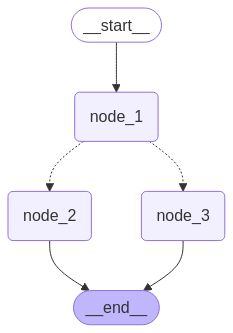

In [32]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Build graph
builder = StateGraph(State)

builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood) # decide_mood is a function which returns a node name (node_2 or node_3)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))
# graph.get_graph().print_ascii()

## **🔮 Graph Invocation with `conditional_edge`**

The input is a dictionary `{"graph_state": "Hi, this is lance."}`, which sets the initial value for our graph state dict.

When `invoke` is called, the graph starts execution from the `START` node.

It progresses through the defined nodes (`node_1`, `node_2`, `node_3`) in order.

The conditional edge will traverse from `node_1` to `node_2` or `node_3` using a `50/50` decision rule. 

Each node function receives the current state and returns a new value, which overrides the graph state.

The execution continues until it reaches the `END` node. 

In [33]:
graph.invoke({"graph_state" : "Hi, this is Lance."})

---Node 1---
---Node 2---


{'graph_state': 'Hi, this is Lance. I am happy!'}

---

## **Example: 🧠🔍📄 RAG Application**
Extract better performance from LLMs by avoiding the inclusion of irrelevant information in the prompt. Therefore, in building this application, we should try to pick the right index to use for each query and use only that one. The key development in this architecture is **to use an LLM to make this decision, effectively using an LLM to evaluate each incoming query and decide which index it should use for that particular query.**

1. An LLM call to pick which of the available indexes to use, given the user-supplied query, and the developer-supplied description of the indexes

2. A retrieval step that queries the chosen index for the most relevant documents for the user query

3. Another LLM call to generate an answer, given the user-supplied query and the list of relevant documents fetched from the index -->

In [34]:
from langchain_core.vectorstores.in_memory import InMemoryVectorStore
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.documents import Document

###############################################################################
# Sample documents for testing
sample_docs = [
    Document(page_content="""
             John Doe is a 40-year-old male presenting with a persistent dry cough and mild shortness of breath that
             started approximately 2 weeks ago. He denies fever, chills, or chest pain. He reports occasional wheezing, which is
             worse at night. There has been no recent travel or exposure to sick contacts. He reports mild improvement with 
             over-the-counter cough syrup but notes that the symptoms have persisted.
             """,
            metadata={"domain": "records"}),


    Document(
        page_content="""
            - Covers expenses for hospital admission, including room charges, nursing care, and medications administered during hospitalization.
            - Room and Board: Covered up to $1,500 per day for a maximum of 30 days per policy year.
            - Intensive Care Unit (ICU): Covered up to $3,000 per day for a maximum of 15 days per policy year.
            - Surgeon’s Fees: 100% coverage for medically necessary surgeries.
            - Anesthesia and Operating Room Charges: Covered in full.
        """, 
        metadata={"domain": "insurance"}
    ),
]


embedding_function = OpenAIEmbeddings(model='text-embedding-3-small')


# Initialize vector stores
medical_records_store = InMemoryVectorStore.from_documents(sample_docs, embedding_function)
medical_records_retriever = medical_records_store.as_retriever()


insurance_faqs_store = InMemoryVectorStore.from_documents(sample_docs, embedding_function)
insurance_faqs_retriever = insurance_faqs_store.as_retriever()

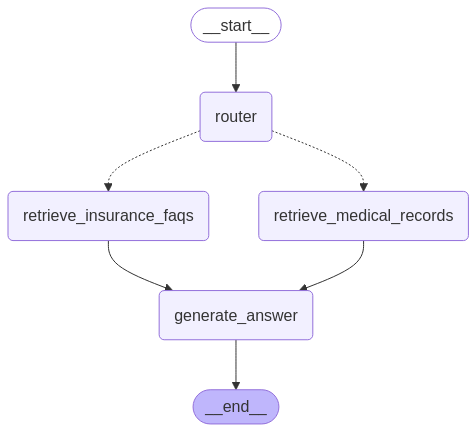

In [35]:
from typing import Annotated, Literal, TypedDict
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.vectorstores.in_memory import InMemoryVectorStore
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages



################################################################################
class State(TypedDict):
    messages: Annotated[list, add_messages] # to track conversation history
    user_query: str  # input
    # output
    domain: Literal["records", "insurance"] # Literal: Restricts the value of domain to one of the predefined choices
    documents: list[Document]
    answer: str



class Input(TypedDict):
    user_query: str



class Output(TypedDict):
    documents: list[Document]
    answer: str


##################################################################################

router_prompt = SystemMessage(
    """You need to decide which domain to route the user query to. You have two domains to choose from:
    - records: contains medical records of the patient, such as diagnosis, treatment, and prescriptions.
    - insurance: contains frequently asked questions about insurance policies, claims, and coverage.

    Output only the domain name."""
)


# useful to generate SQL query
model_low_temp = ChatOpenAI(model='gpt-3.5-turbo', temperature=0.1)

# Node
def router_node(state: State) -> State:# this node calls LLM to check the user query and extract the its domain 
    user_message = HumanMessage(state["user_query"])
    messages = [router_prompt, *state["messages"], user_message]
    res = model_low_temp.invoke(messages)
    return {
        "domain": res.content,
        "messages": [user_message, res],  # update conversation history
    }


# Decision Function
def pick_retriever(state: State,) -> Literal["retrieve_medical_records", "retrieve_insurance_faqs"]: # maps the domain picked by the LLM to one of the two nodes. 
    if state["domain"] == "records":
        return "retrieve_medical_records" # name of the next node to call
    else:
        return "retrieve_insurance_faqs" # name of the next node to call


# Node
def retrieve_medical_records(state: State) -> State:
    documents = medical_records_retriever.invoke(state["user_query"])
    return {
        "documents": documents,
    }

# Node
def retrieve_insurance_faqs(state: State) -> State:
    documents = insurance_faqs_retriever.invoke(state["user_query"])
    return {
        "documents": documents,
    }

#########################################################################################

medical_records_prompt = SystemMessage(
    "You are a helpful medical chatbot, who answers questions based on the patient's medical records, such as diagnosis, treatment, and prescriptions."
)



insurance_faqs_prompt = SystemMessage(
    "You are a helpful medical insurance chatbot, who answers frequently asked questions about insurance policies, claims, and coverage."
)


# useful to generate natural language outputs
model_high_temp = ChatOpenAI(model='gpt-3.5-turbo', temperature=0.7)


# Node
def generate_answer(state: State) -> Output:
    if state["domain"] == "records":
        prompt = medical_records_prompt
    else:
        prompt = insurance_faqs_prompt
    messages = [
        prompt,
        *state["messages"],
        HumanMessage(f"Documents: {state['documents']}"),
    ]
    res = model_high_temp.invoke(messages)
    return {
        "answer": res.content,
        "messages": res,  # update conversation history
    }


builder = StateGraph(State, input=Input, output=Output)

builder.add_node("router", router_node)
builder.add_node("retrieve_medical_records", retrieve_medical_records)
builder.add_node("retrieve_insurance_faqs", retrieve_insurance_faqs)
builder.add_node("generate_answer", generate_answer)

builder.add_edge(START, "router")
builder.add_conditional_edges("router", pick_retriever) # pick_retriever is the decision function
builder.add_edge("retrieve_medical_records", "generate_answer")
builder.add_edge("retrieve_insurance_faqs", "generate_answer")


builder.add_edge("generate_answer", END)

graph = builder.compile()

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [36]:
input = {"user_query": "What medications for COVID-19 treatment?"}

res = graph.invoke(input)
print(res.keys())
res['answer']

dict_keys(['documents', 'answer'])


'Based on the information provided in the medical record, John Doe is presenting with symptoms of a persistent dry cough and mild shortness of breath, with occasional wheezing. Since there is no mention of a confirmed COVID-19 diagnosis, I cannot provide specific medications for COVID-19 treatment in this case.\n\nIt is important for John Doe to consult a healthcare provider for a proper evaluation and diagnosis, especially given the ongoing symptoms. The healthcare provider can determine the appropriate treatment plan based on the specific diagnosis and medical history of the patient. If COVID-19 is suspected, the healthcare provider may recommend treatment options such as antiviral medications, anti-inflammatory drugs, or supportive care based on the severity of symptoms and individual patient factors.'

In [37]:
input = {"user_query": "Does my insurance cover Covid vaccine?"}

res = graph.invoke(input)
print(res.keys())
res['answer']

dict_keys(['documents', 'answer'])


"I'm sorry, I don't have access to your specific insurance policy details. To find out if your insurance covers the Covid vaccine, I recommend checking your policy documents or contacting your insurance provider directly. They will be able to provide you with the most accurate and up-to-date information regarding your coverage for the Covid vaccine."

In [38]:
from pprint import pprint

# Example usage
input = {"user_query": "Does my insurance cover Covid vaccine?"}

for chunk in graph.stream(input):
    pprint(chunk)

{'router': {'domain': 'insurance',
            'messages': [HumanMessage(content='Does my insurance cover Covid vaccine?', additional_kwargs={}, response_metadata={}, id='7ee33955-7e45-4062-90f9-ef36c679466c'),
                         AIMessage(content='insurance', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 2, 'prompt_tokens': 83, 'total_tokens': 85, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BMmU0kpBb6Tnv8CkOsCou3r1nyWdj', 'finish_reason': 'stop', 'logprobs': None}, id='run-10fd4688-9881-48a7-a0a0-5fddfaa28c2d-0', usage_metadata={'input_tokens': 83, 'output_tokens': 2, 'total_tokens': 85, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]

## **✅ `.invoke()` VS `.stream()`**

| Setting              | Affects `.stream()`?         | How?                                                       |
|----------------------|-------------------------------|-------------------------------------------------------------|
| `input=InputState`   | ✅ Yes                        | Validates input before the graph starts executing           |
| `output=OutputState` | ❌ No                         | Streaming emits raw `OverallState` chunks (not filtered)    |
| `output=OutputState` | ✅ Yes (in `.invoke()`)       | Final result is trimmed to just the keys in `OutputState`   |
